# Lokaverkefni TÖL403G 2025

## Höfundar
Sigurður Ari Stefánsson

Svava Þóra Árnadóttir

## imports

In [1]:
import pandas as pd
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time
from math import sqrt


# Liður 2.3.1 (*) 

### Þáttun

Lesið inn netið úr skránum sem eru gefnar, nodes.tsv og edges.tsv. Í skránni nodes.tsv
eru hnútar með auðkenni (id), hnit (x, y) og hvort þeir séu á aðalvegi (primary). Í skránni
edges.tsv eru leggi frá hnúti u til hnúts v með lengd length, mæld í metrum, og nafn
(name).

In [3]:
# Lesa og hreinsa gögn 
nodes_df = pd.read_csv('nodes.tsv', sep='\t', header=0, names=['id', 'x', 'y', 'primary'])
edges_df = pd.read_csv('edges.tsv', sep='\t', header=0, names=['u', 'v', 'length', 'name'])

nodes_df = nodes_df[nodes_df['id'] != 'osmid']
edges_df = edges_df[edges_df['u'] != 'u']

nodes_df['id'] = nodes_df['id'].astype(int)
nodes_df['x'] = nodes_df['x'].astype(float)
nodes_df['y'] = nodes_df['y'].astype(float)
nodes_df['primary'] = nodes_df['primary'].astype(bool)

edges_df['u'] = edges_df['u'].astype(int)
edges_df['v'] = edges_df['v'].astype(int)
edges_df['length'] = edges_df['length'].astype(float)


# Liður 2.3.2 (**)

### Leit

Ef við setjum hleðslustöðvar á hnúta v1, . . . , vk þá er hægt að nota reikniritið dijkstra til að
finna stystu fjarlægð frá hnverjum hnúti u í hleðslustöð vi. Útfærið reikniritið sem tekur
inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. Athugið að netið
er stefnt net.

In [5]:
# Multi-source Dijkstra: reiknar stystu leið í einhverja hleðslustöð
def dijkstra_to_charging(graph, charging_nodes):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    reversed_graph = defaultdict(list)

    # Snúa netinu við til þess að reikna vegalengd frá hnút að stöð
    for u in graph:
        for v, weight in graph[u]:
            reversed_graph[v].append((u, weight))

    # Upphafsstilla fjarlægðir á hleðslustöðvum sem 0 og setja á heap. 
    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    visited_count = 0
        
    # Leit
    while heap:
        current_dist, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        visited_count += 1

        for v, weight in reversed_graph[u]:
            if dist[v] > current_dist + weight:
                dist[v] = current_dist + weight
                heapq.heappush(heap, (dist[v], v))

    #print(f"Dijkstra visited {visited_count} nodes.")
    return dist


In [6]:
# breytir punkt í google maps link
gmaps_urls = {}
for _, row in nodes_df.iterrows():
    gmaps_urls[row['id']] = f"https://www.google.com/maps?q={row['y']},{row['x']}"

print(gmaps_urls[12885922])

https://www.google.com/maps?q=64.0319775,-22.0878904


# Liður 2.3.3 (*)

### Framsetning

Setjið fimm hleðslustöðvar í netið og sýnið stystu leið fyrir fimm punkta og teiknið upp á
kort. Tékkið ykkur af með því að bera saman leiðina sem er fundin og fjarlægðina miðað
við kortavefi eins og t.d. Google Maps.

Distance to station for node 1186616568: 1061.9433348008124m
Distance to station for node 241784654: 3539.156663593519m
Distance to station for node 11641311433: 9879.794632032172m
Distance to station for node 11137114625: 1436.7909221999978m
Distance to station for node 253469037: 4346.811123446911m


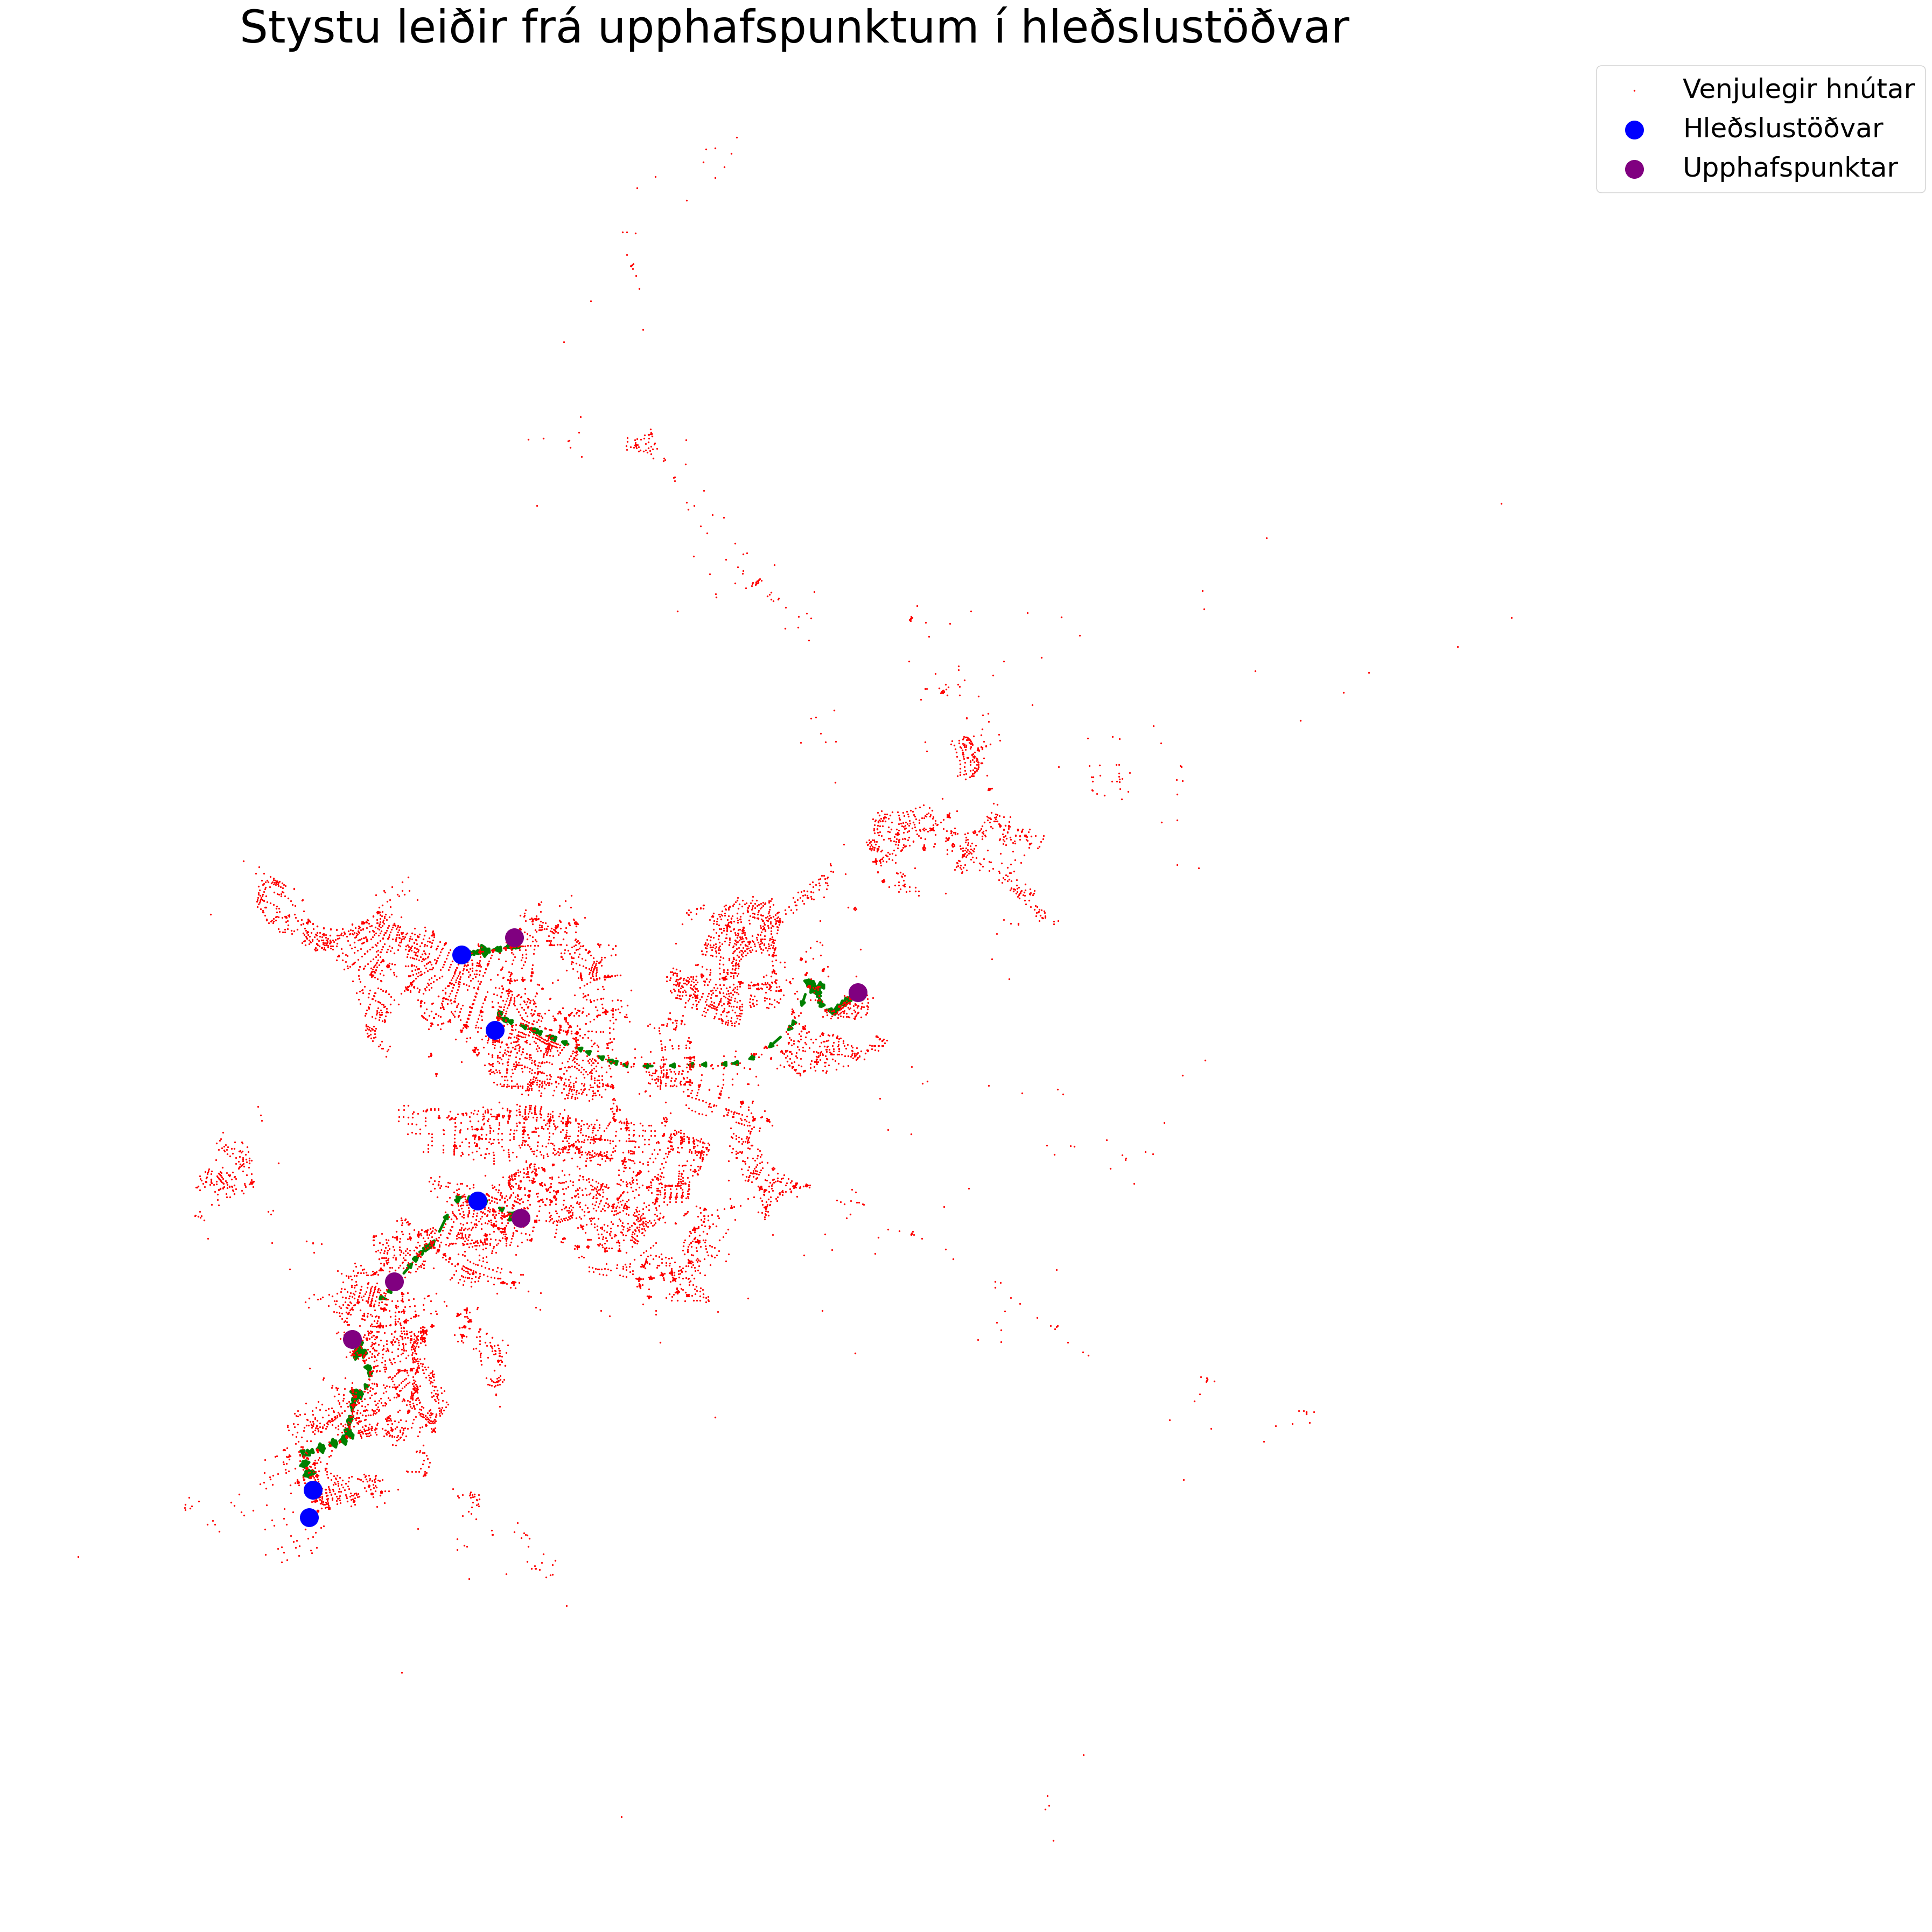

Start Node:  1186616568
https://www.google.com/maps?q=64.0955512,-21.8883475
Start Node:  241784654
https://www.google.com/maps?q=64.0835592,-21.9453247
Start Node:  11641311433
https://www.google.com/maps?q=64.1378368,-21.7361517
Start Node:  11137114625
https://www.google.com/maps?q=64.1481539,-21.8911121
Start Node:  253469037
https://www.google.com/maps?q=64.072827,-21.9643267
Charging Node:  26481023
https://www.google.com/maps?q=64.1449961,-21.914858
Charging Node:  2325888359
https://www.google.com/maps?q=64.1307609,-21.8999934
Charging Node:  5098498898
https://www.google.com/maps?q=64.0393631,-21.9836985
Charging Node:  599332607
https://www.google.com/maps?q=64.0444857,-21.9820114
Charging Node:  297899459
https://www.google.com/maps?q=64.0987287,-21.9076808


In [7]:
# 1. Búa til stefnt net: u -> listi af (v, length)
graph = defaultdict(list)
for _, row in edges_df.iterrows():
    graph[row['u']].append((row['v'], row['length']))


# 2. Finna hvaða hnútar eru hleðslustöðvar (primary == True)
all_charging_stations = nodes_df[nodes_df['primary'] == True]['id'].tolist()

# 3. Velja 5 random hleðslustöðvar með seedi.
random.seed(420)

charging_station_nodes = random.sample(all_charging_stations, 5)


# 4. Velja 5 random upphafshnúta sem EKKI eru hleðslustöðvar
non_stations = nodes_df[~nodes_df['id'].isin(charging_station_nodes)]
start_nodes = random.sample(non_stations['id'].tolist(), 5)

# 5. Reikna stystu vegalengdir að næstu hleðslustöð
shortest_to_station = dijkstra_to_charging(graph, charging_station_nodes)

# 6. Setja niðurstöðurnar í DataFrame
distances_df = pd.DataFrame([
    {'id': node_id, 'distance_to_station': shortest_to_station[node_id]}
    for node_id in nodes_df['id']
])

# 7. Birta hnútana sem eru valdir
for node in start_nodes:
    distance = distances_df.loc[distances_df['id'] == node, 'distance_to_station'].values
    print(f"Distance to station for node {node}: {distance[0]}m")


# 8. Leitarfall: Dijkstra leið frá einum hnút í næstu stöð til að teikna
def dijkstra_path(graph, start, stations):
    dist = {node: float('inf') for node in nodes_df['id']}
    dist[start] = 0
    prev = {}
    heap = [(0, start)]
    while heap:
        d, u = heapq.heappop(heap)
        # ATH
        if u in stations:
            break
        for v, w in graph[u]:
            if dist[v] > d + w:
                dist[v] = d + w
                prev[v] = u
                heapq.heappush(heap, (dist[v], v))
    found = min([(station, dist[station]) for station in stations if dist[station] < float('inf')], key=lambda x: x[1], default=(None, None))
    if found[0] is None:
        return []
    path = []
    current = found[0]
    while current != start:
        path.append(current)
        current = prev[current]
    path.append(start)
    return list(reversed(path))


# 9. Teikna netið 
G = nx.DiGraph()

## notað í A* líka
node_positions = {}

for _, row in nodes_df.iterrows():
    node_id = row['id']
    node_positions[node_id] = (row['x'], row['y'])
    G.add_node(node_id)
for _, row in edges_df.iterrows():
    G.add_edge(row['u'], row['v'], length=row['length'])

plt.figure(figsize=(30, 30), dpi=120)

# 9.1. Venjulegir hnútar
non_charging_nodes = [n for n in G.nodes if n not in charging_station_nodes]
nx.draw_networkx_nodes(G, node_positions, nodelist=non_charging_nodes, node_color='red', node_size=1, label='Venjulegir hnútar')

# 9.2. Hleðslustöðvar
nx.draw_networkx_nodes(G, node_positions, nodelist=charging_station_nodes, node_color='blue', node_size=400, label='Hleðslustöðvar')

# 9.3. Upphafshnútar
nx.draw_networkx_nodes(G, node_positions, nodelist=start_nodes, node_color='purple', node_size=400, label='Upphafspunktar')

# 9.4. Leggir
#nx.draw_networkx_edges(G, node_positions, alpha=0.3, arrows=True, arrowstyle='-|>', arrowsize=8, width=0.3)

# 9.5. Teikna stystu leiðir
for start in start_nodes:
    path = dijkstra_path(graph, start, charging_station_nodes)
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='green', width=3)

plt.title("Stystu leiðir frá upphafspunktum í hleðslustöðvar", fontsize=50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
plt.axis('off')
plt.tight_layout()
plt.show()

for v in start_nodes:
    print('Start Node: ', v)
    print(gmaps_urls[v])

for v in charging_station_nodes:
    print('Charging Node: ', v)
    print(gmaps_urls[v])


In [8]:
shortest_to_station[9207425915]

1618.0305930408974

# Liður 2.3.4 (*)

### Tímamælingar

Mælið tímann sem reikniritið dijkstra tekur að reikna allar fjarlægðir í netinu með fimm
hleðslustöðvum.

In [9]:
start_time = time.time()
shortest_to_station_time = dijkstra_to_charging(graph, charging_station_nodes)
end_time = time.time()

total_time = end_time - start_time

print(f"Tími fyrir Dijkstra fyrir allla punkta í 5 hleðslustöðvar: {total_time:.4f} sek")

Tími fyrir Dijkstra fyrir allla punkta í 5 hleðslustöðvar: 0.0240 sek


# Liður 2.3.5 (**)

### A* reikniritið

Útfærið A⋆ reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öll-
um hnútum í netinu. Sem neðra mat á fjarlægð á milli hnútanna má taka $d(u, v) = \sqrt{(x_u − x_v )^2 + (y_u − y_v )^2}$, þ.e. beina loftlínu milli punktanna. Mælið tíma og berið saman
við reiknirit Dijkstra.

In [10]:
# Útgáfa Sigga
def lower_estimate(node_id, charging_stations, pos):
    x1, y1 = pos[node_id]
    return min(
        sqrt((x1 - pos[station][0])**2 + (y1 - pos[station][1])**2)
        for station in charging_stations
    )

# A*: reiknar stystu leið í einhverja hleðslustöð
# tekur inn net, hleðslustöðvar/target nodes og staðsetningar (x, y) upplýsingar um hvern hnút.  
def a_star_to_charging(graph, charging_nodes, pos):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    # snúa netinu við, til að reikna frá hverjum hnút að stöð
    reversed_graph = defaultdict(list)
    for u in graph:
        for v, weight in graph[u]:
            reversed_graph[v].append((u, weight))
            
    # Upphafsstilla fjarlægðir á hleðslustöðvum sem 0 og setja á heap. 
    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    visited_count = 0
        
    # Leit
    while heap:
        _, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        visited_count += 1

        for v, weight in reversed_graph[u]:
            d = dist[u] + weight
            if d < dist[v]:
                dist[v] = d
                euc = lower_estimate(v, charging_nodes, pos)
                heapq.heappush(heap, (d + euc, v))

    #print(f"A* visited {visited_count} nodes.")
    return dist


# Keyrir á sama tíma og dijkstra því þau leita á svipaðann hátt því euc distance er ekki nógu stórt til að hafa áhrif
# gætum prufað að setja hleðslustöðvar út í öll horn eða eh og sjá hvort það kemur munur 
start_time = time.time()
a_star = a_star_to_charging(graph, charging_station_nodes, node_positions)
end_time = time.time()

total_time = end_time - start_time
print(f"Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar {total_time:.4f} sek")

Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar 0.0490 sek


# Liður 2.3.6 (**)

### Staðsetning hleðslustöðva

Ef við setjum k hleðslustöðvar í hnúta $v_1, . . . , v_k$ þá látum við markfallið vera

$$F(v_1,...,v_k) = \sum_{u \in V} \underset{i=1,...,k}{min} d(u,v_i)$$

þ.e. fyrir hvern hnút í netinu reiknum við stystu fjarlægð frá honum til næstu hleðslustöðvar
og leggjum saman yfir alla hnúta í netinu.

Finnið bestu lausn fyrir k = 1, með því að prófa alla hnúta sem hægt er að setja
hleðslustöð í og veljið þann sem gefur minnsta markfall. Athugið að eingöngu þeir hnútar
sem eru merktir sem primary geta verið hleðslustöðvar.

In [11]:
best_station = None
mark = float('inf')
count = 0

for station in all_charging_stations:
    distances = dijkstra_to_charging(graph, [station])

    total = 0

    for node_id in distances:
        if distances[node_id] == float('inf'):
            # Bæta við stórri tölu ef dist er inf eins og í hnút 5541083892, bæti við 50km
            total += 50000
        else:
            total += distances[node_id]

    #print(f"Stöð {station} hefur markfallið {total}.")
    count += 1

    if total < mark:
        mark = total
        best_station = station
    #print(f"Minnsta markfallið hingað til er {mark} frá stöð {best_station}.")


print(f"Besta hleðslustöðin er {best_station} með markfallið  {mark}.")
print(gmaps_urls[best_station])
print(f"Fjöldi athugaðra hleðslustöðva er {count}")
    

Besta hleðslustöðin er 34827739 með markfallið  72442102.57913065.
https://www.google.com/maps?q=64.1140749,-21.8457362
Fjöldi athugaðra hleðslustöðva er 1829


# Liður 2.3.7 (**)

### Gráðug reiknirit

Útfærið gráðugt reiknirit sem leitar að bestu lausn fyrir $k = 2, . . . , 10$ með því að leysa
vandamálið fyrir k−1 hleðslustöðvum og bæta þá við þann hnút sem gefur minnsta markfall,
miðað við að ekki sé hægt að breyta $v_1, . . . , v_{k−1}$
Sýnið á korti hvaða hleðslustöðvar eru valdar fyrir k = 10 og mælið tímann sem reikniritið
tekur.

k = 1: 34827739 með markfallið 72442102.5791305
k = 2: 4159611763 með markfallið 55943648.9669397
k = 3: 470316424 með markfallið 44854264.121764205
k = 4: 1204996745 með markfallið 38072391.0504463
k = 5: 470320635 með markfallið 34978692.907693364
k = 6: 253702373 með markfallið 32607435.773555417
k = 7: 2948755314 með markfallið 30478702.90154548
k = 8: 62975525 með markfallið 28429906.153171424
k = 9: 252165232 með markfallið 26957405.504667412
k = 10: 251765347 með markfallið 25531386.67095511
Gráðuga reikniritið tók 495.12 sekúndur


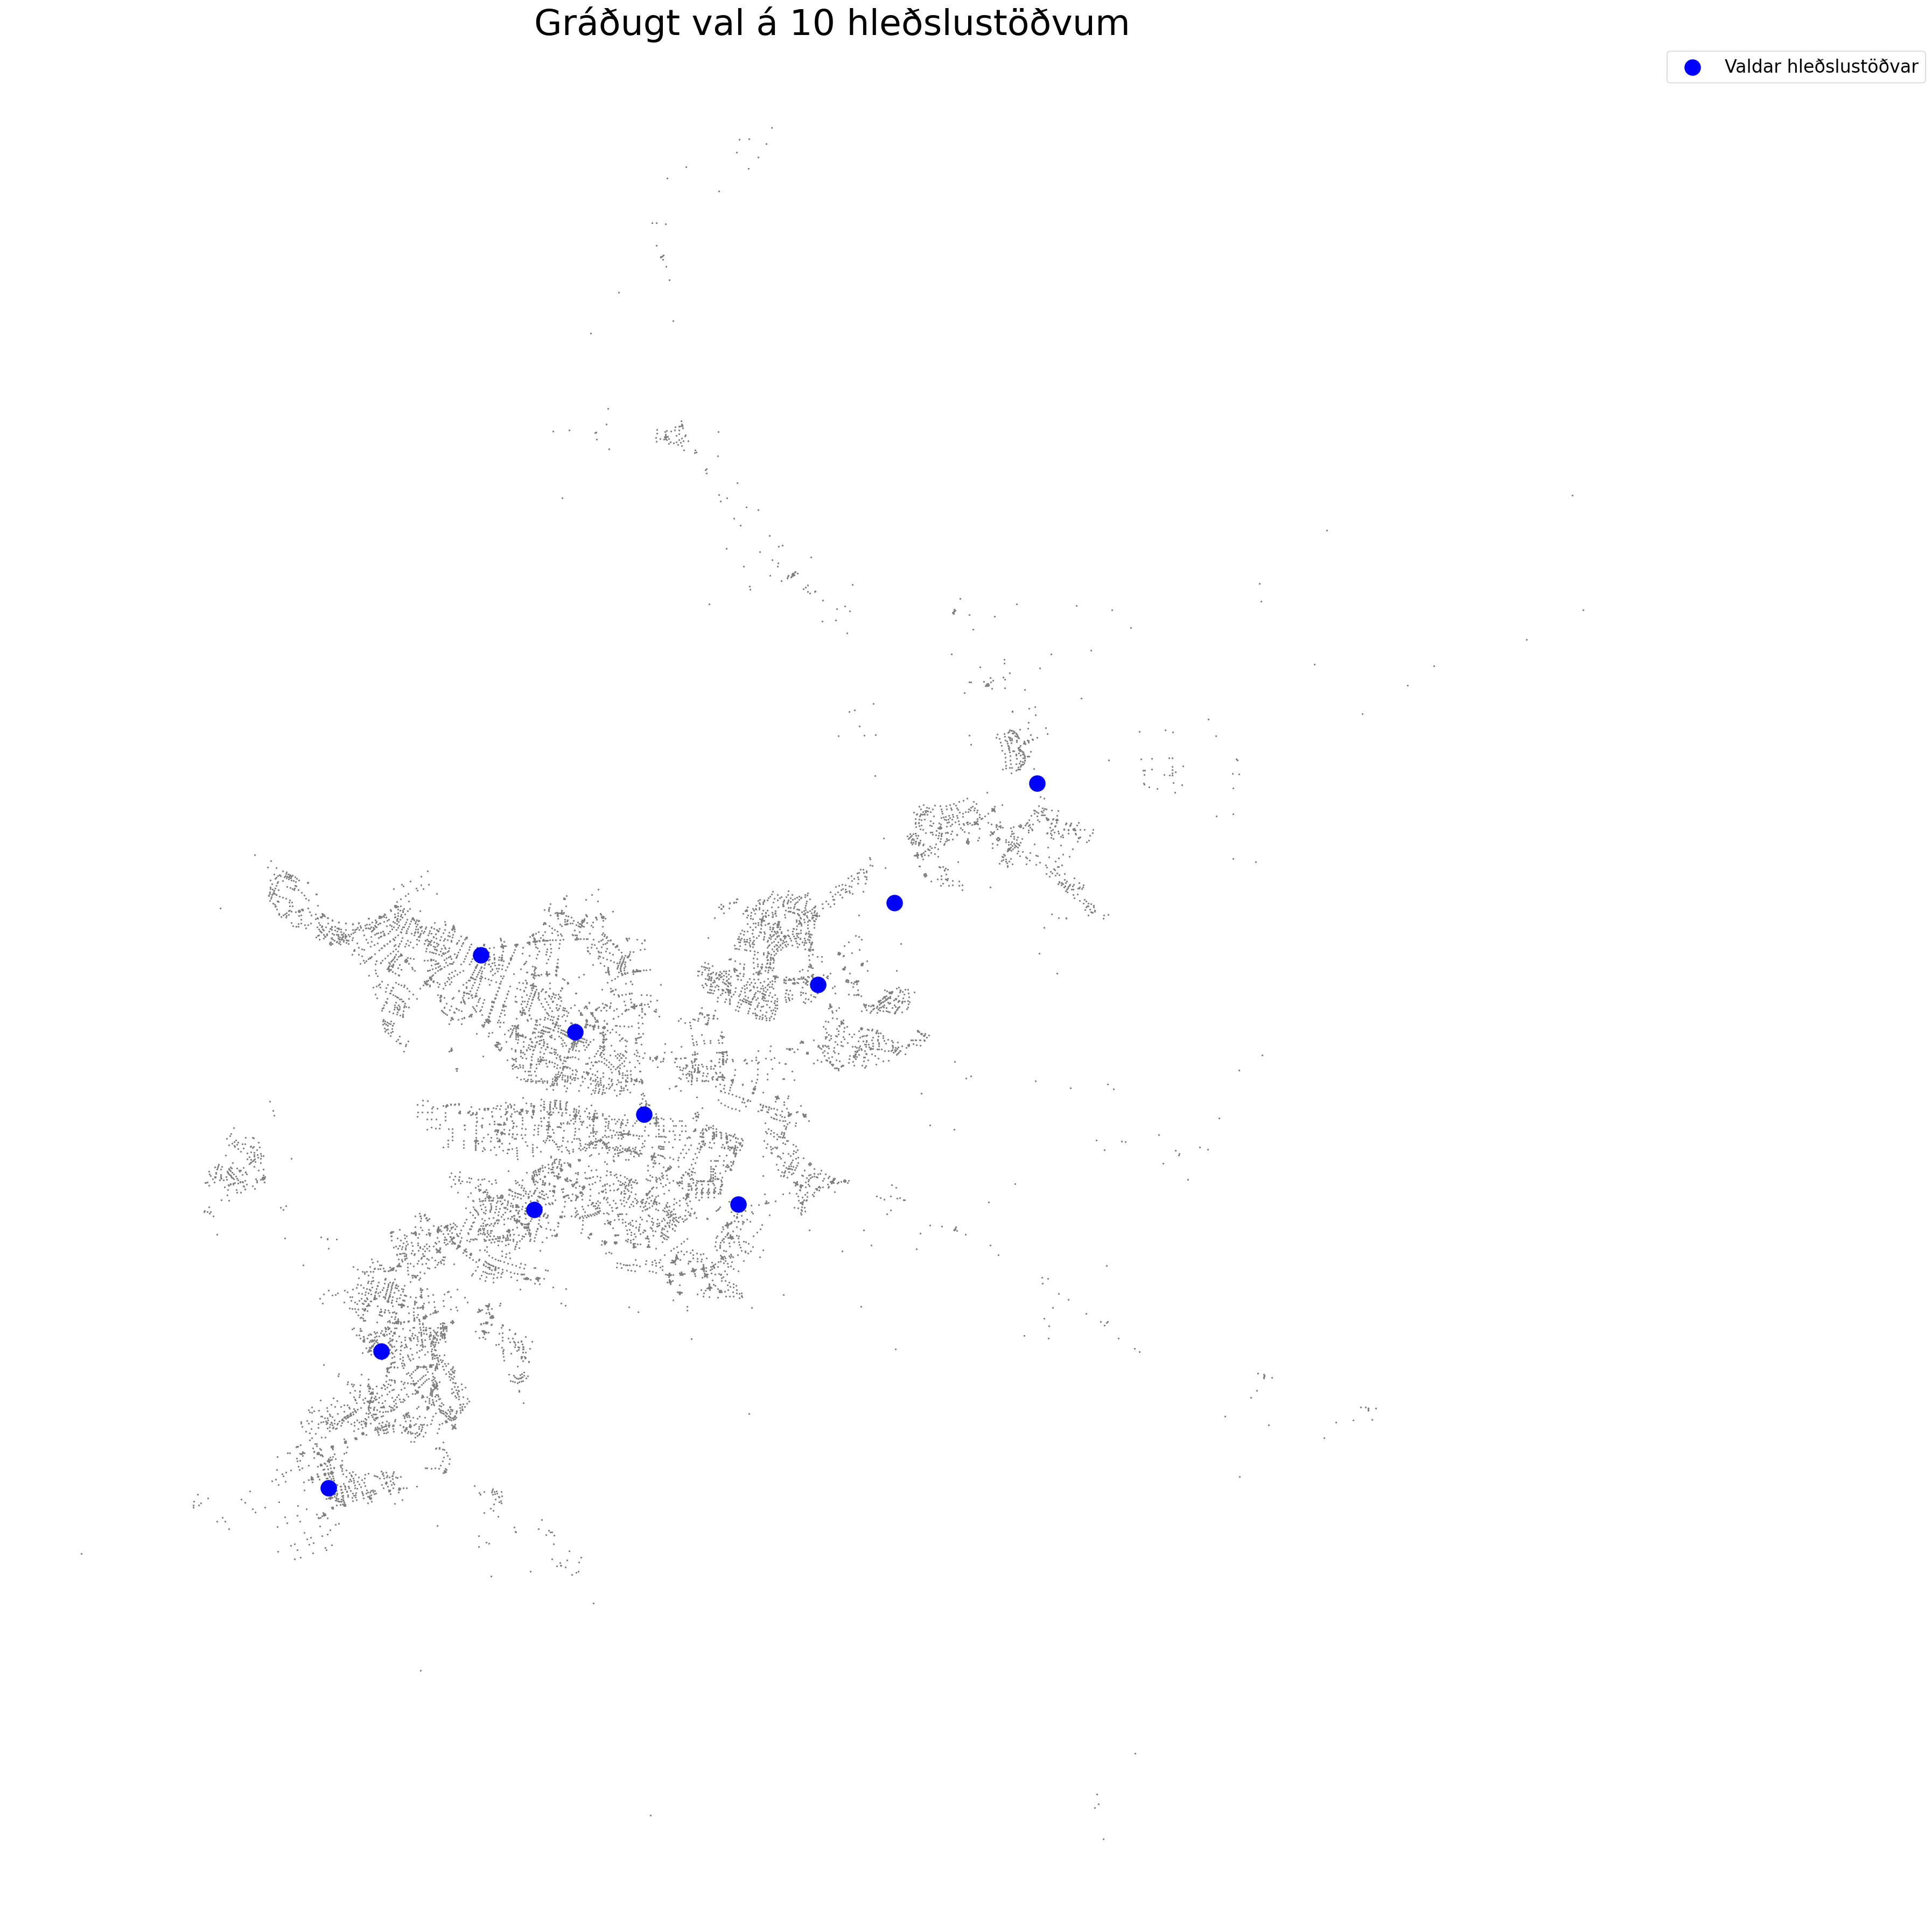

1. Hnútur: 34827739 — https://www.google.com/maps?q=64.1140749,-21.8457362
2. Hnútur: 4159611763 — https://www.google.com/maps?q=64.0698109,-21.9588732
3. Hnútur: 470316424 — https://www.google.com/maps?q=64.1536212,-21.7379318
4. Hnútur: 1204996745 — https://www.google.com/maps?q=64.143833,-21.9158807
5. Hnútur: 470320635 — https://www.google.com/maps?q=64.0963001,-21.8929091
6. Hnútur: 253702373 — https://www.google.com/maps?q=64.1383465,-21.7708875
7. Hnútur: 2948755314 — https://www.google.com/maps?q=64.0973264,-21.805228
8. Hnútur: 62975525 — https://www.google.com/maps?q=64.1759499,-21.6765716
9. Hnútur: 252165232 — https://www.google.com/maps?q=64.0442398,-21.9816643
10. Hnútur: 251765347 — https://www.google.com/maps?q=64.1294204,-21.8754605


In [12]:
def greedy_station_selection(graph, candidate_nodes, k_max, best_station, best_mark):
    chosen_stations = []

    start_time = time.time()

    # Notum bestu stöðina úr lið 2.3.6
    chosen_stations.append(best_station)
    print(f"k = 1: {best_station} með markfallið {best_mark}")

    # Gráðugt reiknirit: Bætir við einni stöð í einu, alltaf þeirri sem lágmarkar markfallið best
    for k in range(2, k_max + 1):
        best_new = None
        best_mark = float('inf')
        for node in candidate_nodes:
            if node in chosen_stations:
                continue
            # Prófar að bæta einum nýjum hnút við núverandi valda hnúta
            test_stations = chosen_stations + [node]
            dists = dijkstra_to_charging(graph, test_stations)
            total = sum([d if d != float('inf') else 50000 for d in dists.values()])
            if total < best_mark:
                best_mark = total
                best_new = node
        # Velur þann hnút sem bætti markfallið mest og bætir við í mengi stöðva
        chosen_stations.append(best_new)
        print(f"k = {k}: {best_new} með markfallið {best_mark}")

    end_time = time.time()
    print(f"Gráðuga reikniritið tók {end_time - start_time:.2f} sekúndur")

    return chosen_stations

# Keyra gráðuga leit fyrir k=10 hleðslustöðvar
greedy_stations_k10 = greedy_station_selection(graph, all_charging_stations, 10, best_station, mark)

# Teikna netið og valdar stöðvar á kortið
plt.figure(figsize=(30, 30), dpi=120)

# Teikna alla hnúta sem litla gráa punkta
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=1)

# Teikna þær stöðvar sem voru valdar í gráðugu leitinni
nx.draw_networkx_nodes(G, node_positions, nodelist=greedy_stations_k10, node_color='blue', node_size=300, label='Valdar hleðslustöðvar')

# Titill
plt.title("Gráðugt val á 10 hleðslustöðvum", fontsize=40)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()


# Prenta staðsetningar á valdum stöðvum með Google Maps hlekk
for i, s in enumerate(greedy_stations_k10):
    print(f"{i+1}. Hnútur: {s} — {gmaps_urls[s]}")


# Liður 2.3.8 (**)

### Skárri gráðug reiknirit

Gráðuga reikniritið á það til að mála sig út í horn með því að velja lélegan fyrsta hnút.
Breytið leitinni þannig að þið veljið handahófskenndan fyrsta hnút og farið endurkvæmt í
tilfellin $k = 2, . . . , 10.$ Í hverju undirtilfelli finnið þið 2 bestu hnútana sem koma til greina
en eru langt frá hvor öðrum og prófið endurkvæmt alla möguleika. Haldið utan um bestu
lausnina sem finnst fyrir nokkur hanndahófskennda upphafspunkta og sýnið bestu lausn á
korti. Hve mikinn tíma tekur reikniritið ykkar?


 Tilraun 1: Upphafshnútur: 1186616568
Lausn fyrir tilraun 1 : [1186616568, 1208295841, 241779370, 2325775096, 14772879, 257168753, 36166172, 26756902, 6382150947, 252165202], Markfall: 24184784.80

 Tilraun 2: Upphafshnútur: 1225420711
Lausn fyrir tilraun 2 : [1225420711, 1203320099, 241779370, 470316424, 251765347, 1203904360, 470320635, 62975525, 2948755314, 6382150947], Markfall: 25154861.79

 Tilraun 3: Upphafshnútur: 5023088942
Lausn fyrir tilraun 3 : [5023088942, 1208295841, 241779370, 2325775096, 14772879, 257168753, 26756902, 36166172, 6382150947, 6187992752], Markfall: 24412180.44

 Tilraun 4: Upphafshnútur: 87114610
Lausn fyrir tilraun 4 : [87114610, 626182586, 470316420, 2325775096, 980895970, 257168753, 2948755314, 26756902, 62975525, 6382150947], Markfall: 26053816.46

 Tilraun 5: Upphafshnútur: 33719469
Lausn fyrir tilraun 5 : [33719469, 241786018, 470316420, 1550882370, 269072778, 2320771866, 257168753, 62975525, 87366131, 6382150947], Markfall: 24623500.00

Heildartími

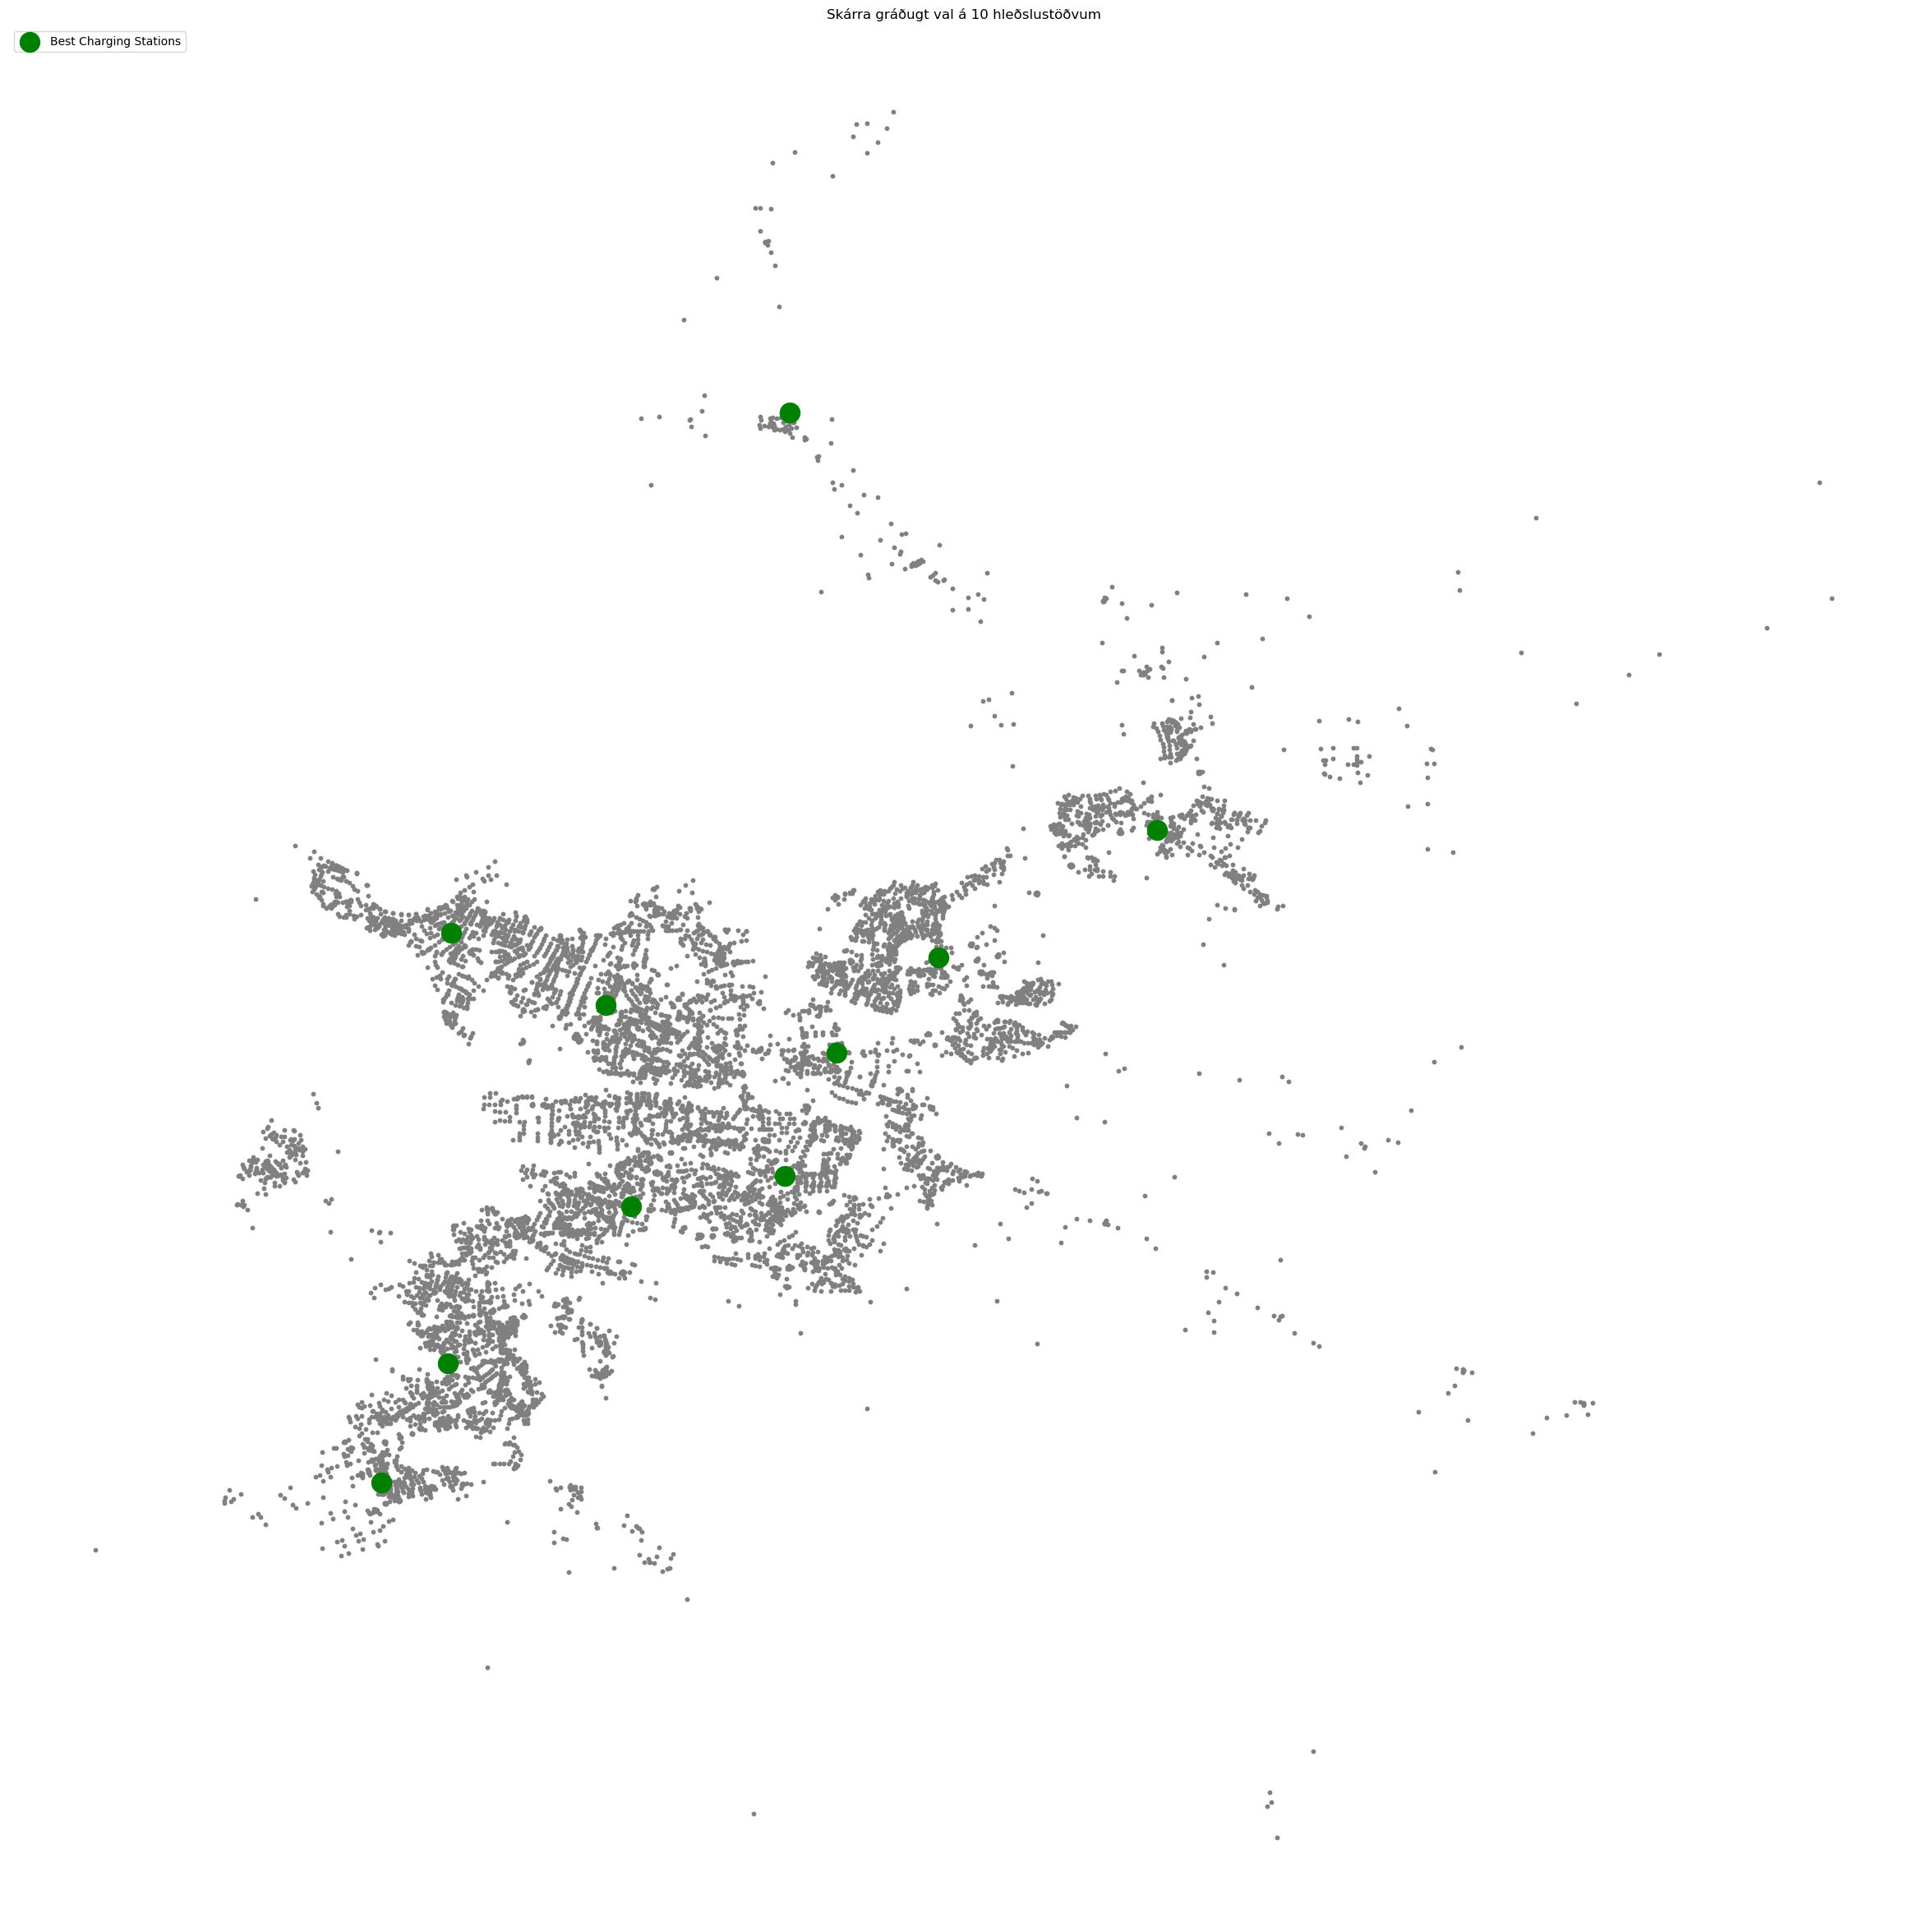

In [38]:
import random
import time
import matplotlib.pyplot as plt
import networkx as nx

# Ný útgáfa, veit ekki hvort þetta er rétt

DIST_MIN = 0.01  # lágmarksfjarlægð milli stöðva (í sömu einingum og node_positions)

# Athugar hvort hnútur sé nógu langt frá núverandi stöðvum
def is_far_enough(candidate, current_stations, node_positions, min_dist):
    for s in current_stations:
        x1, y1 = node_positions[candidate]
        x2, y2 = node_positions[s]
        dist = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        if dist < min_dist:
            return False
    return True

def compute_objective(graph, charging_nodes):
    dists = dijkstra_to_charging(graph, charging_nodes)
    return sum([d if d != float('inf') else 50000 for d in dists.values()])

def improved_greedy(graph, candidates, current_stations, k, cached_improvements=None):
    if cached_improvements is None:
        cached_improvements = {}
    
    if len(current_stations) == k:
        return current_stations, compute_objective(graph, current_stations)
    
    curr_cost = compute_objective(graph, current_stations)
    
    candidate_list = []
    for node in candidates:
        if node in current_stations:
            continue
        # Lágmarksfjarlægðarskilyrði
        if not is_far_enough(node, current_stations, node_positions, DIST_MIN):
            continue
        if node not in cached_improvements:
            candidate_cost = compute_objective(graph, current_stations + [node])
            improvement = curr_cost - candidate_cost
            cached_improvements[node] = improvement
        candidate_list.append(node)
    
    candidate_list.sort(key=lambda node: cached_improvements[node], reverse=True)
    
    best_two = []
    for node in candidate_list:
        # Ef við höfum þegar tvö besta gildi og cached gildið er minna en lægsta bót,
        # sleppum við frekari útreikningum.
        if len(best_two) == 2 and cached_improvements[node] < min(x[2] for x in best_two):
            break
        candidate_cost = compute_objective(graph, current_stations + [node])
        new_imp = curr_cost - candidate_cost
        cached_improvements[node] = new_imp
        best_two.append((node, candidate_cost, new_imp))
        best_two = sorted(best_two, key=lambda tup: tup[1])[:2]
    
    best_result = None
    best_value = float('inf')
    for candidate, candidate_cost, _ in best_two:
        new_stations = current_stations + [candidate]
        result, val = improved_greedy(graph, candidates, new_stations, k, cached_improvements)
        if val < best_value:
            best_value = val
            best_result = result
    
    return best_result, best_value

# Framkvæmum nokkrar (5) tilraunir á skárra gráðuga reiknirita fyrir 10 hleðslustöðvar
def run_improved_greedy_multiple(graph, candidates, k=10, trials=5):
    best_overall = None
    best_score = float('inf')
    start_time = time.time()

    for i in range(trials):
        first = random.choice(candidates)
        print(f"\n Tilraun {i+1}: Upphafshnútur: {first}")
        result, score = improved_greedy(graph, candidates, [first], k)
        print(f"Lausn fyrir tilraun {i+1} : {result}, Markfall: {score:.2f}")
        if score < best_score:
            best_overall = result
            best_score = score

    end_time = time.time()
    print(f"\nHeildartími: {end_time - start_time:.2f} sekúndur")
    return best_overall, best_score

# Keyrum improved_greedy 5 sinnum
best_improved_stations, best_mark_value = run_improved_greedy_multiple(graph, all_charging_stations, k=10, trials=5)

print("\nBesta lausn fengin með skárra gráðugu reikniriti:")
for i, s in enumerate(best_improved_stations):
    print(f"{i+1}. Hnútur: {s} — {gmaps_urls[s]}")
print(f"Markfall: {best_mark_value:.2f}")

plt.figure(figsize=(30, 30))
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=10)
nx.draw_networkx_nodes(G, node_positions, nodelist=best_improved_stations, node_color='green', node_size=300, label='Best Charging Stations')
plt.title("Skárra gráðugt val á 10 hleðslustöðvum")
plt.legend(loc='upper left')
plt.axis('off')
plt.show()


In [ ]:
# Gamla útgáfan, aðeins betra markfall en nokkuð viss um að við séum ekki að nota tvær bestu með langri fjarlægð

import random
import time
import matplotlib.pyplot as plt
import networkx as nx

def compute_objective(graph, charging_nodes):
    dists = dijkstra_to_charging(graph, charging_nodes)
    return sum([d if d != float('inf') else 50000 for d in dists.values()])

def improved_greedy(graph, candidates, current_stations, k, cached_improvements=None):
    if cached_improvements is None:
        cached_improvements = {}
    
    if len(current_stations) == k:
        return current_stations, compute_objective(graph, current_stations)
    
    curr_cost = compute_objective(graph, current_stations)
    
    candidate_list = []
    for node in candidates:
        if node in current_stations:
            continue
        if node not in cached_improvements:
            candidate_cost = compute_objective(graph, current_stations + [node])
            improvement = curr_cost - candidate_cost
            cached_improvements[node] = improvement
        candidate_list.append(node)
    
    candidate_list.sort(key=lambda node: cached_improvements[node], reverse=True)
    
    best_two = []
    for node in candidate_list:
        # Ef við höfum þegar tvö besta gildi og cached gildið er minna en lægsta bót,
        # sleppum við frekari útreikningum.
        if len(best_two) == 2 and cached_improvements[node] < min(x[2] for x in best_two):
            break
        candidate_cost = compute_objective(graph, current_stations + [node])
        new_imp = curr_cost - candidate_cost
        cached_improvements[node] = new_imp
        best_two.append((node, candidate_cost, new_imp))
        best_two = sorted(best_two, key=lambda tup: tup[1])[:2]
    
    best_result = None
    best_value = float('inf')
    for candidate, candidate_cost, _ in best_two:
        new_stations = current_stations + [candidate]
        result, val = improved_greedy(graph, candidates, new_stations, k, cached_improvements)
        if val < best_value:
            best_value = val
            best_result = result
    
    return best_result, best_value

# Framkvæmum nokkrar (5) tilraunir á skárra gráðuga reiknirita fyrir 10 hleðslustöðvar
def run_improved_greedy_multiple(graph, candidates, k=10, trials=5):
    best_overall = None
    best_score = float('inf')
    start_time = time.time()

    for i in range(trials):
        first = random.choice(candidates)
        print(f"\n Tilraun {i+1}: Upphafshnútur: {first}")
        result, score = improved_greedy(graph, candidates, [first], k)
        print(f"Lausn fyrir tilraun {i+1} : {result}, Markfall: {score:.2f}")
        if score < best_score:
            best_overall = result
            best_score = score

    end_time = time.time()
    print(f"\nHeildartími: {end_time - start_time:.2f} sekúndur")
    return best_overall, best_score


# Keyrum improved_greedy 5 sinnum
best_improved_stations, best_mark_value = run_improved_greedy_multiple(graph, all_charging_stations, k=10, trials=5)

print("\nBesta lausn fengin með skárra gráðugu reikniriti:")
for i, s in enumerate(best_improved_stations):
    print(f"{i+1}. Hnútur: {s} — {gmaps_urls[s]}")
print(f"Markfall: {best_mark_value:.2f}")

plt.figure(figsize=(30, 30))
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=10)
nx.draw_networkx_nodes(G, node_positions, nodelist=best_improved_stations, node_color='green', node_size=300, label='Best Charging Stations')
plt.title("Skárra gráðugt val á 10 hleðslustöðvum")
plt.legend(loc='upper left')
plt.axis('off')
plt.show()

# Liður 2.3.9 (***)

### Nákvæm lausn fyrir k=10

Finnið bestu lausn fyrir k = 10 með því að setja vandamálið upp sem heiltölubestunarverk-
efni (e. integer linear program) og leysa það með því að nota pakka á borð við Gurobi eða
OR-tools. Athugið að verkefnið gæti verið of stórt fyrir þessa pakka. Nýtið ykkur götur í
hverfum eru oft teng við primary hnúta í gegnum einn veg, þá er hægt að einfalda netið með
því að skipta þessum hverfum út fyrir einn hnút sem tengir sameiginlegan primary hnút.
Þessa leggi er hægt að finna með DFS. Sýnið bestu lausnina á korti og mælið tímann sem
heiltölubestunarverkefnið tekur.


[({2353472512, 87372289, 2320796689, 35787282, 2353472540, 1821021213, 1896201758, 2320796703, 2373924902, 1550882358, 2320796727, 2320789560, 1550882361, 4857685049, 76001341, 560670782, 2320789566, 1550882370, 4857685061, 1550882376, 290048586, 4857685066, 2320760396, 2320796748, 582291541, 4857685078, 286732895, 582291552, 6974308450, 2320813172, 6575649410, 1889922181, 241785992, 2320813197, 241785490, 5037141653, 5037141660, 1135532700, 241786018, 349330100, 9462979273, 61273289, 538191051, 61273292, 1571682505, 538191055, 10993155796, 323368149, 9462979287, 14581975, 1186615001, 10993155817, 1186616568, 1536991992, 538191116, 1536992012, 1552212754, 1086046995, 349327637, 4487713047, 2320771864, 2320771865, 2988478746, 4487713052, 2320771871, 1203320099, 286837542, 4053115690, 2320771884, 326277421, 5023088940, 349327663, 349327661, 286838068, 5023088949, 1203320120, 326277434, 286838075, 470330176, 241785153, 241785154, 1908085063, 443930954, 661505354, 2323580748, 326277452, 32

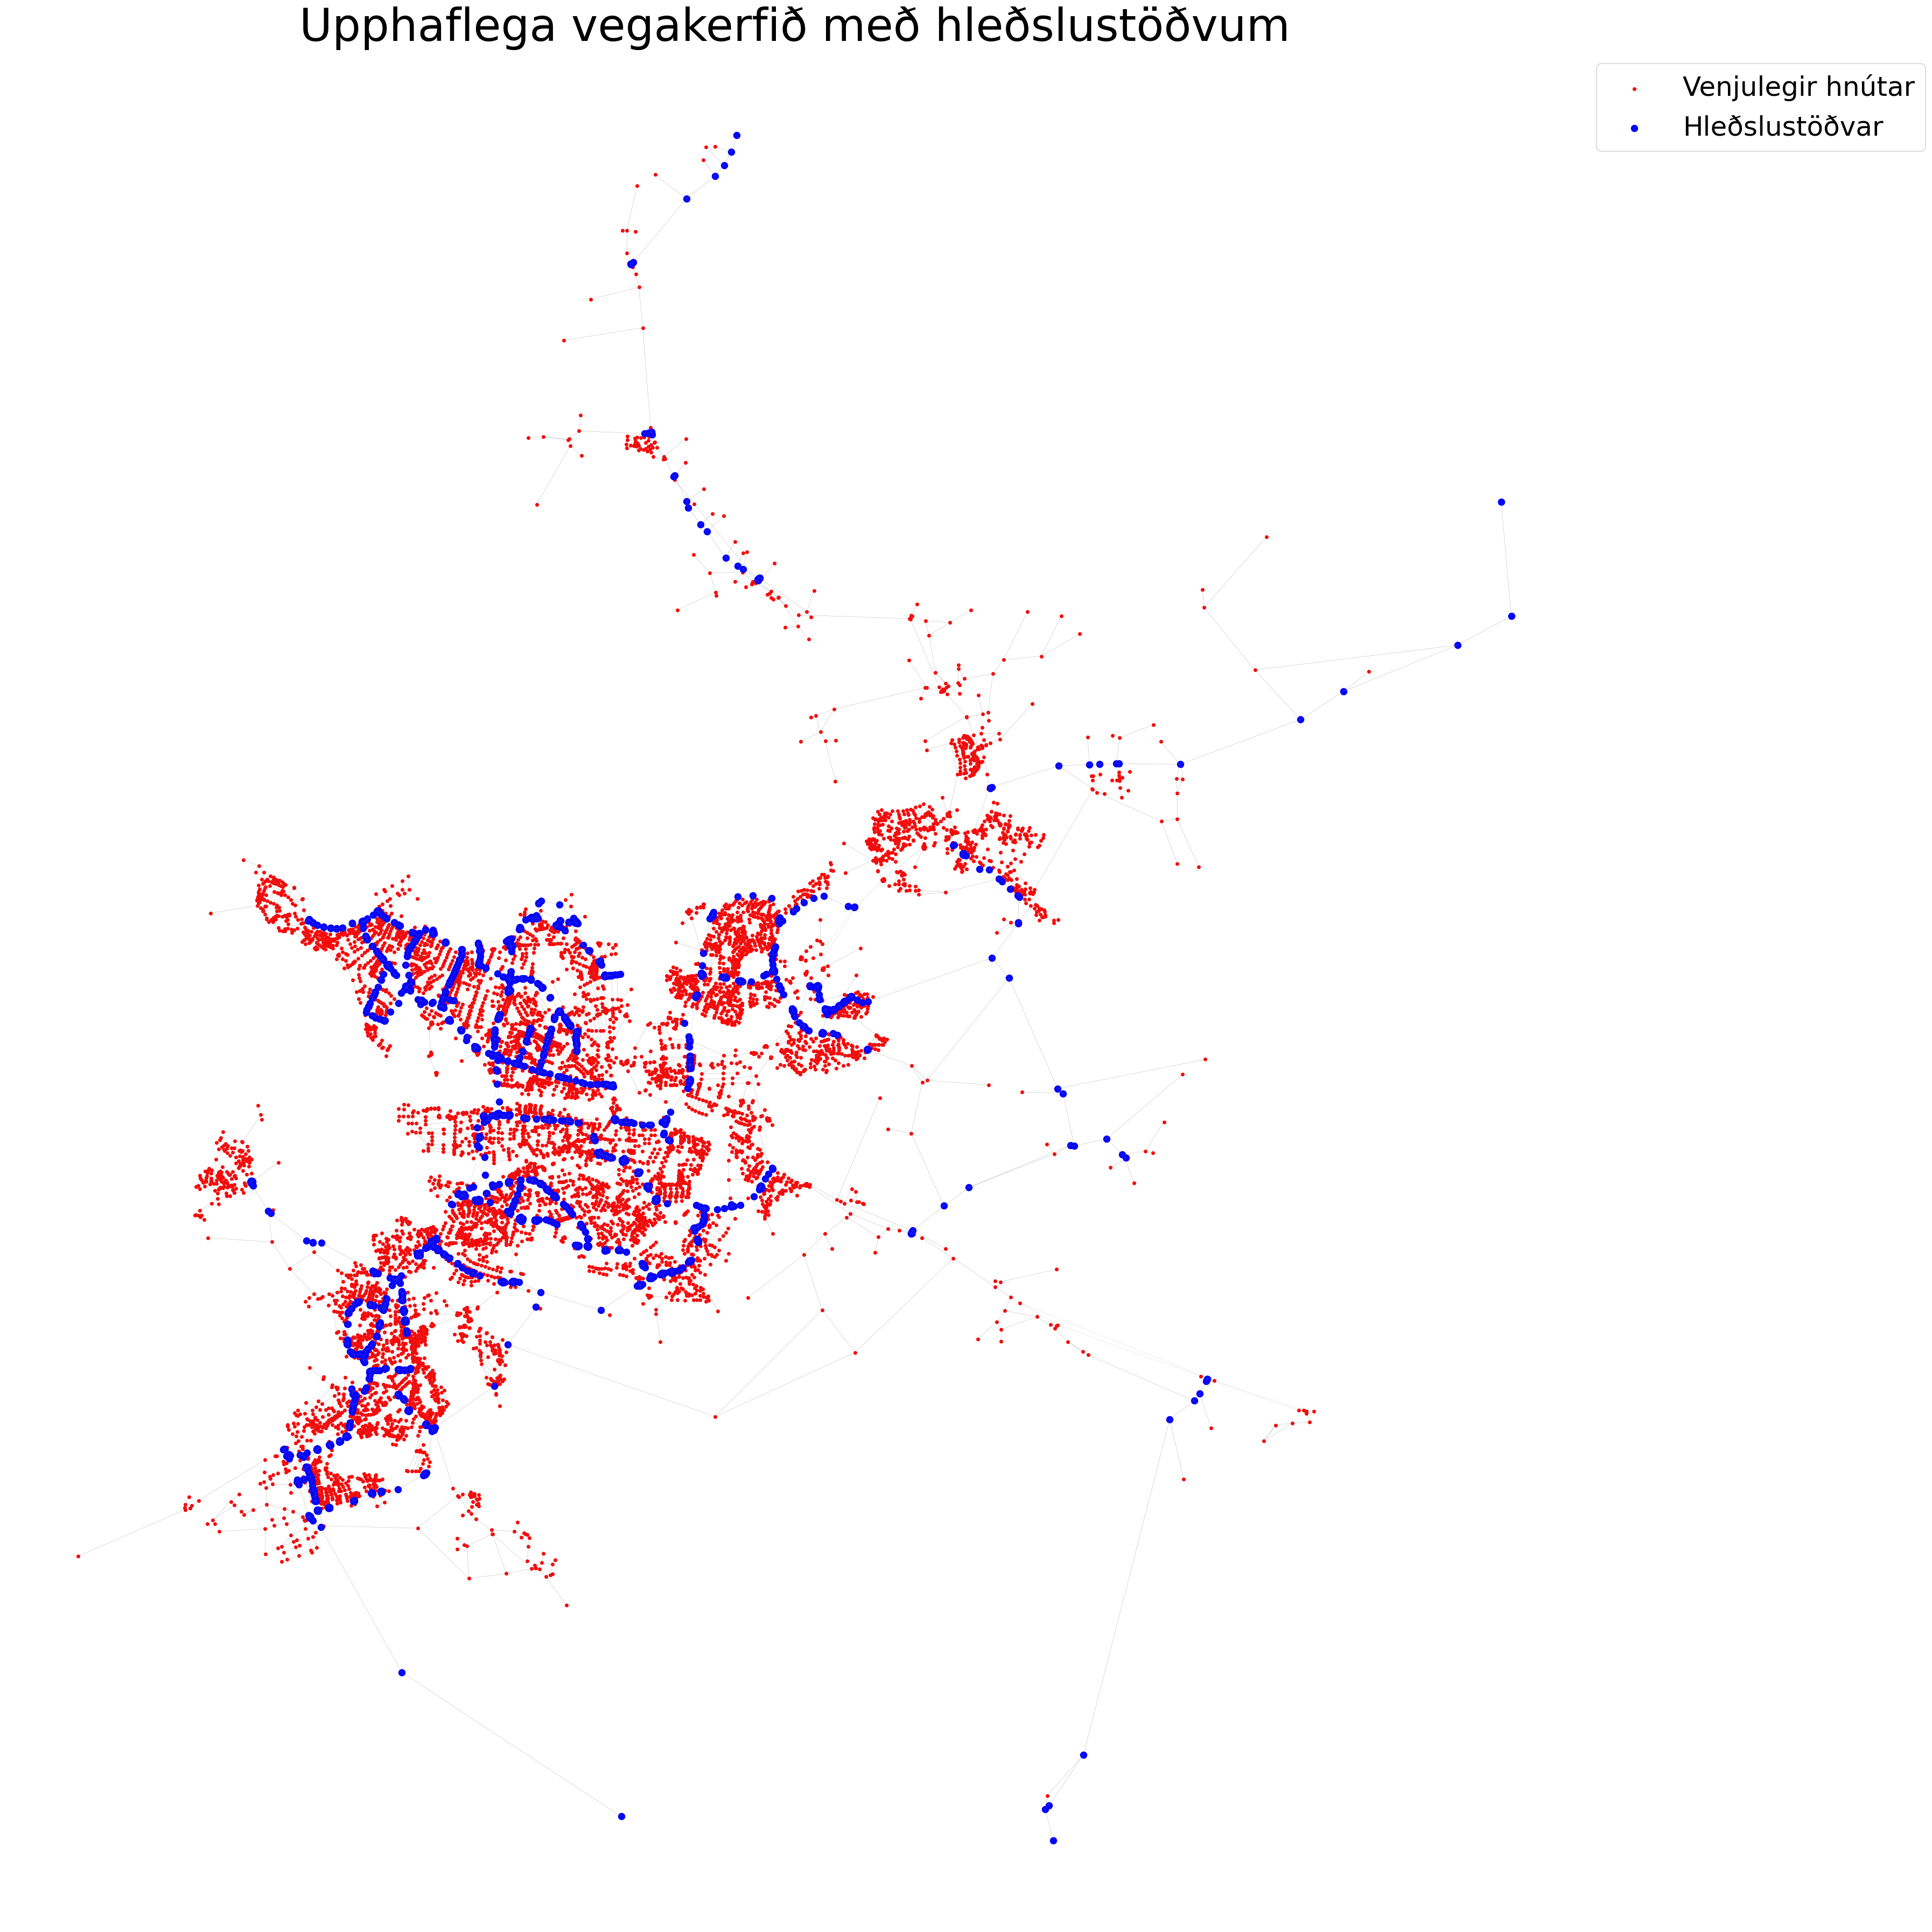

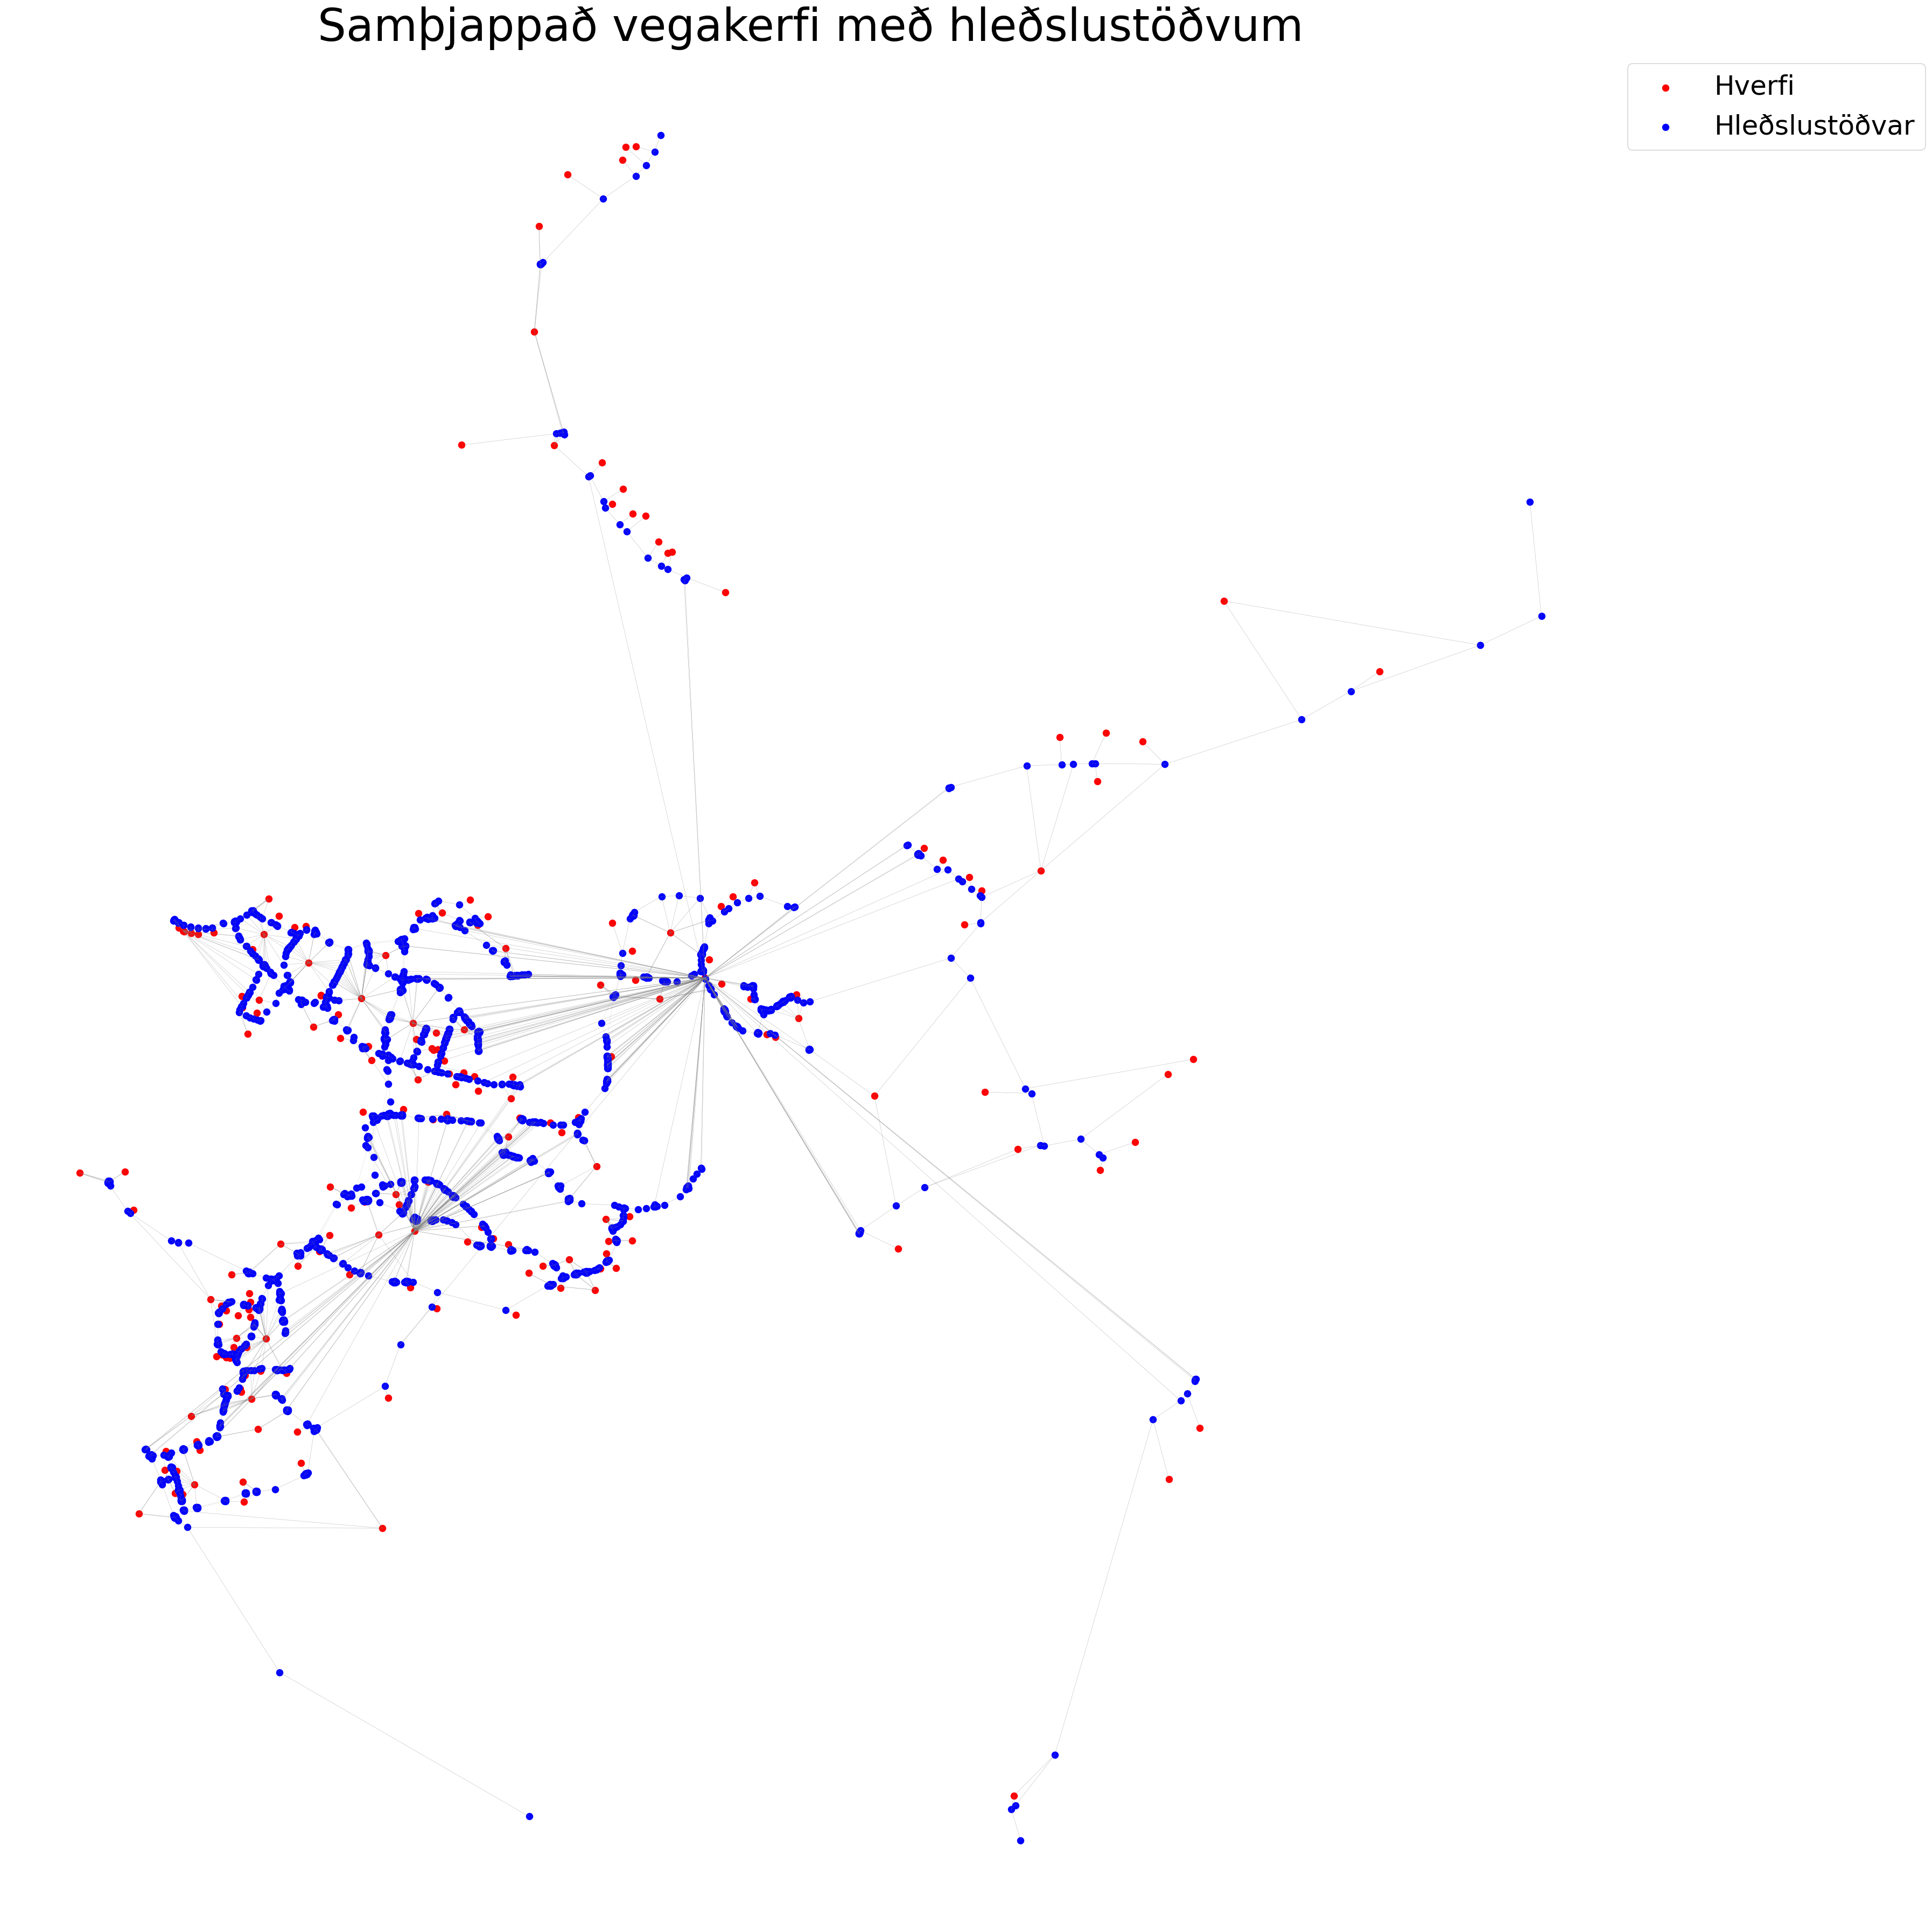

In [39]:
# finnur einföldun
def find_neighborhoods(graph, nodes_df):
    """
    Finnur hverfi í grafi sem ekki innihalda primary hnúta og skilar tengdum primary hnútum ef þeir eru til.
    """

    # Búa til hjálpar dictionary fyrir primary lookup
    primary_dict = dict(zip(nodes_df['id'], nodes_df['primary']))

    # Gera óstefnt graf (til að fanga sama edge-case og í networkX: to_undirected)
    undirected_graph = defaultdict(set)
    for u in graph:
        for v, _ in graph[u]:
            undirected_graph[u].add(v)
            undirected_graph[v].add(u)

    visited = set()
    collapsible = []

    for node in undirected_graph.keys():
        if primary_dict.get(node, False) or node in visited:
            continue

        stack = [node]
        neighborhood = set()
        connected_primaries = set()

        while stack:
            current = stack.pop()
            if current in neighborhood or current in connected_primaries:
                continue

            if primary_dict.get(current, False):
                connected_primaries.add(current)
                continue
            else:
                neighborhood.add(current)
                visited.add(current)

            for neighbor in undirected_graph[current]:
                if neighbor not in visited and neighbor not in connected_primaries:
                    stack.append(neighbor)

        collapsible.append((connected_primaries, neighborhood))

    return collapsible

collapsible = find_neighborhoods(graph, nodes_df)
print(collapsible)


from copy import deepcopy
# býr til nýtt net
def create_simplified_graph(graph, nodes_df, collapsible):
    """
    Býr til nýtt net út frá gamla neti og hnútum og upplýsingum úr find_neighborhoods
    """
    # Copy graph
    collapsed_graph = deepcopy(graph)

    # Build lookup dictionaries for nodes
    x_dict = dict(zip(nodes_df['id'], nodes_df['x']))
    y_dict = dict(zip(nodes_df['id'], nodes_df['y']))

    for primaries, neighborhood in collapsible:
        total_x = sum(x_dict[node] for node in neighborhood)
        total_y = sum(y_dict[node] for node in neighborhood)
        count = len(neighborhood)

        if count == 0:
            continue  # skip empty neighborhoods

        average_x = total_x / count
        average_y = total_y / count

        collapsed_node = next(iter(neighborhood))  # pick representative node

        # Remove all neighborhood nodes from the graph
        for node in neighborhood:
            if node in collapsed_graph:
                del collapsed_graph[node]
        # Also remove edges pointing *to* neighborhood nodes
        for node in collapsed_graph:
            collapsed_graph[node] = [(v, l) for v, l in collapsed_graph[node] if v not in neighborhood]

        # Add the new collapsed node
        collapsed_graph[collapsed_node] = []

        # Update nodes_df with the new node
        nodes_df = nodes_df[nodes_df['id'].isin(set(nodes_df['id']) - neighborhood)]
        nodes_df = pd.concat([nodes_df, pd.DataFrame([{
            'id': collapsed_node,
            'x': average_x,
            'y': average_y,
            'primary': False
        }])], ignore_index=True)

        for primary in primaries:
            # Dijkstra from primary
            distances = dijkstra_to_charging(graph, [primary])  # use original graph for distances

            total_distance = 0
            reachable_nodes = 0

            for node in neighborhood:
                if distances.get(node, float('inf')) < float('inf'):
                    total_distance += distances[node]
                    reachable_nodes += 1

            if reachable_nodes > 0:
                average_distance = total_distance / reachable_nodes

                # Add bidirectional edges
                collapsed_graph[primary].append((collapsed_node, average_distance))
                collapsed_graph[collapsed_node].append((primary, average_distance))

    return collapsed_graph, nodes_df

collapsed_graph, collapsed_nodes_df = create_simplified_graph(graph, nodes_df, collapsible)
print(collapsed_graph)
print(collapsed_nodes_df)


import matplotlib.pyplot as plt

# teiknar samþjappaða netið
def plot_simplified_graph(collapsed_graph, collapsed_nodes_df):
    plt.figure(figsize=(30, 30), dpi=120)

    # Búa til node_positions úr dataframe
    node_positions = {row['id']: (row['x'], row['y']) for _, row in collapsed_nodes_df.iterrows()}

    # Venjulegir hnútar (non-primary)
    non_primary_nodes = collapsed_nodes_df[collapsed_nodes_df['primary'] == False]['id'].tolist()
    plt.scatter(
        [node_positions[n][0] for n in non_primary_nodes],
        [node_positions[n][1] for n in non_primary_nodes],
        c='red',
        s=50,  # stærri svo auðveldara sé að sjá þá í samdrættinum
        label='Hverfi'
    )

    # Hleðslustöðvar (primary)
    primary_nodes = collapsed_nodes_df[collapsed_nodes_df['primary'] == True]['id'].tolist()
    plt.scatter(
        [node_positions[n][0] for n in primary_nodes],
        [node_positions[n][1] for n in primary_nodes],
        c='blue',
        s=50,
        label='Hleðslustöðvar'
    )

    # Teikna edge línur úr collapsed_graph
    for u, neighbors in collapsed_graph.items():
        for v, weight in neighbors:
            if u in node_positions and v in node_positions:
                x_coords = [node_positions[u][0], node_positions[v][0]]
                y_coords = [node_positions[u][1], node_positions[v][1]]
                plt.plot(x_coords, y_coords, alpha=0.3, linewidth=0.3, color='gray')

    plt.title("Samþjappað vegakerfi með hleðslustöðvum", fontsize=50)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# teiknar venjulega netið
def plot_original_graph(graph, nodes_df, charging_station_nodes):
    plt.figure(figsize=(30, 30), dpi=120)

    # Búa til node_positions úr nodes_df
    node_positions = {row['id']: (row['x'], row['y']) for _, row in nodes_df.iterrows()}

    # Venjulegir hnútar (non-primary)
    non_charging_nodes = nodes_df[nodes_df['primary'] == False]['id'].tolist()
    plt.scatter(
        [node_positions[n][0] for n in non_charging_nodes],
        [node_positions[n][1] for n in non_charging_nodes],
        c='red',
        s=10,
        label='Venjulegir hnútar'
    )

    # Hleðslustöðvar (primary)
    plt.scatter(
        [node_positions[n][0] for n in charging_station_nodes],
        [node_positions[n][1] for n in charging_station_nodes],
        c='blue',
        s=50,
        label='Hleðslustöðvar'
    )

    # Teikna edge línur
    for u, neighbors in graph.items():
        for v, weight in neighbors:
            if u in node_positions and v in node_positions:
                x_coords = [node_positions[u][0], node_positions[v][0]]
                y_coords = [node_positions[u][1], node_positions[v][1]]
                plt.plot(x_coords, y_coords, alpha=0.3, linewidth=0.3, color='gray')

    plt.title("Upphaflega vegakerfið með hleðslustöðvum", fontsize=50)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_original_graph(graph, nodes_df, all_charging_stations)
plot_simplified_graph(collapsed_graph, collapsed_nodes_df)

In [41]:
import gurobipy as gp
from gurobipy import GRB, quicksum

# 1. Búa til umhverfi og setja WLS leyfislyklana
env = gp.Env(empty=True)
env.setParam("WLSACCESSID", "ec441f09-85a5-4d1c-9efd-6284706f0abb")
env.setParam("WLSSECRET",   "f4b1bd53-6176-42a0-991f-c818d056aebe")
env.setParam("LICENSEID",   2650686)
env.setParam("TimeLimit",   2400)

# 2. Ræsa umhverfið
env.start()

# 3. Reiknifallið sjálft
def optimize_charging_station_placement(graph, k=10):
    # Passa að nota env=env svo módelið noti þetta sérstaka umhverfi
    model = gp.Model("charging_station_placement", env=env)
    
    nodes = list(graph.keys())

    x = model.addVars(nodes, vtype=GRB.BINARY, name="station")
    y = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="assign")

    shortest_distances = {}
    for station_candidate in nodes:
        distances = dijkstra_to_charging(graph, [station_candidate])
        for node in nodes:
            d = distances[node]
            if d == float('inf'):
                d = 50000
            shortest_distances[(node, station_candidate)] = d

    model.setObjective(
        quicksum(shortest_distances[(i, j)] * y[i, j] for i in nodes for j in nodes),
        GRB.MINIMIZE
    )

    model.addConstr(quicksum(x[j] for j in nodes) == k, name="num_stations")

    for i in nodes:
        model.addConstr(quicksum(y[i, j] for j in nodes) == 1, name=f"assign_{i}")
        for j in nodes:
            model.addConstr(y[i, j] <= x[j], name=f"use_station_{i}_{j}")

    model.optimize()

    selected_stations = [j for j in nodes if x[j].X > 0.5]
    return selected_stations

# 4. Keyra bestunina
best_stations = optimize_charging_station_placement(collapsed_graph, k=10)
print("Best station locations:", best_stations)


Set parameter TimeLimit to value 2400
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2650686
Academic license 2650686 - for non-commercial use only - registered to st___@hi.is
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 22.4.0 22E252)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  2400

Academic license 2650686 - for non-commercial use only - registered to st___@hi.is
Optimize a model with 4122931 rows, 4122930 columns and 12364730 nonzeros
Model fingerprint: 0xcfbcca28
Variable types: 0 continuous, 4122930 integer (4122930 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 2.328207e+07
Presolve removed 0 rows and 0 columns (presolve time = 5s)...
Presolve removed 0 rows and 0 columns (pres

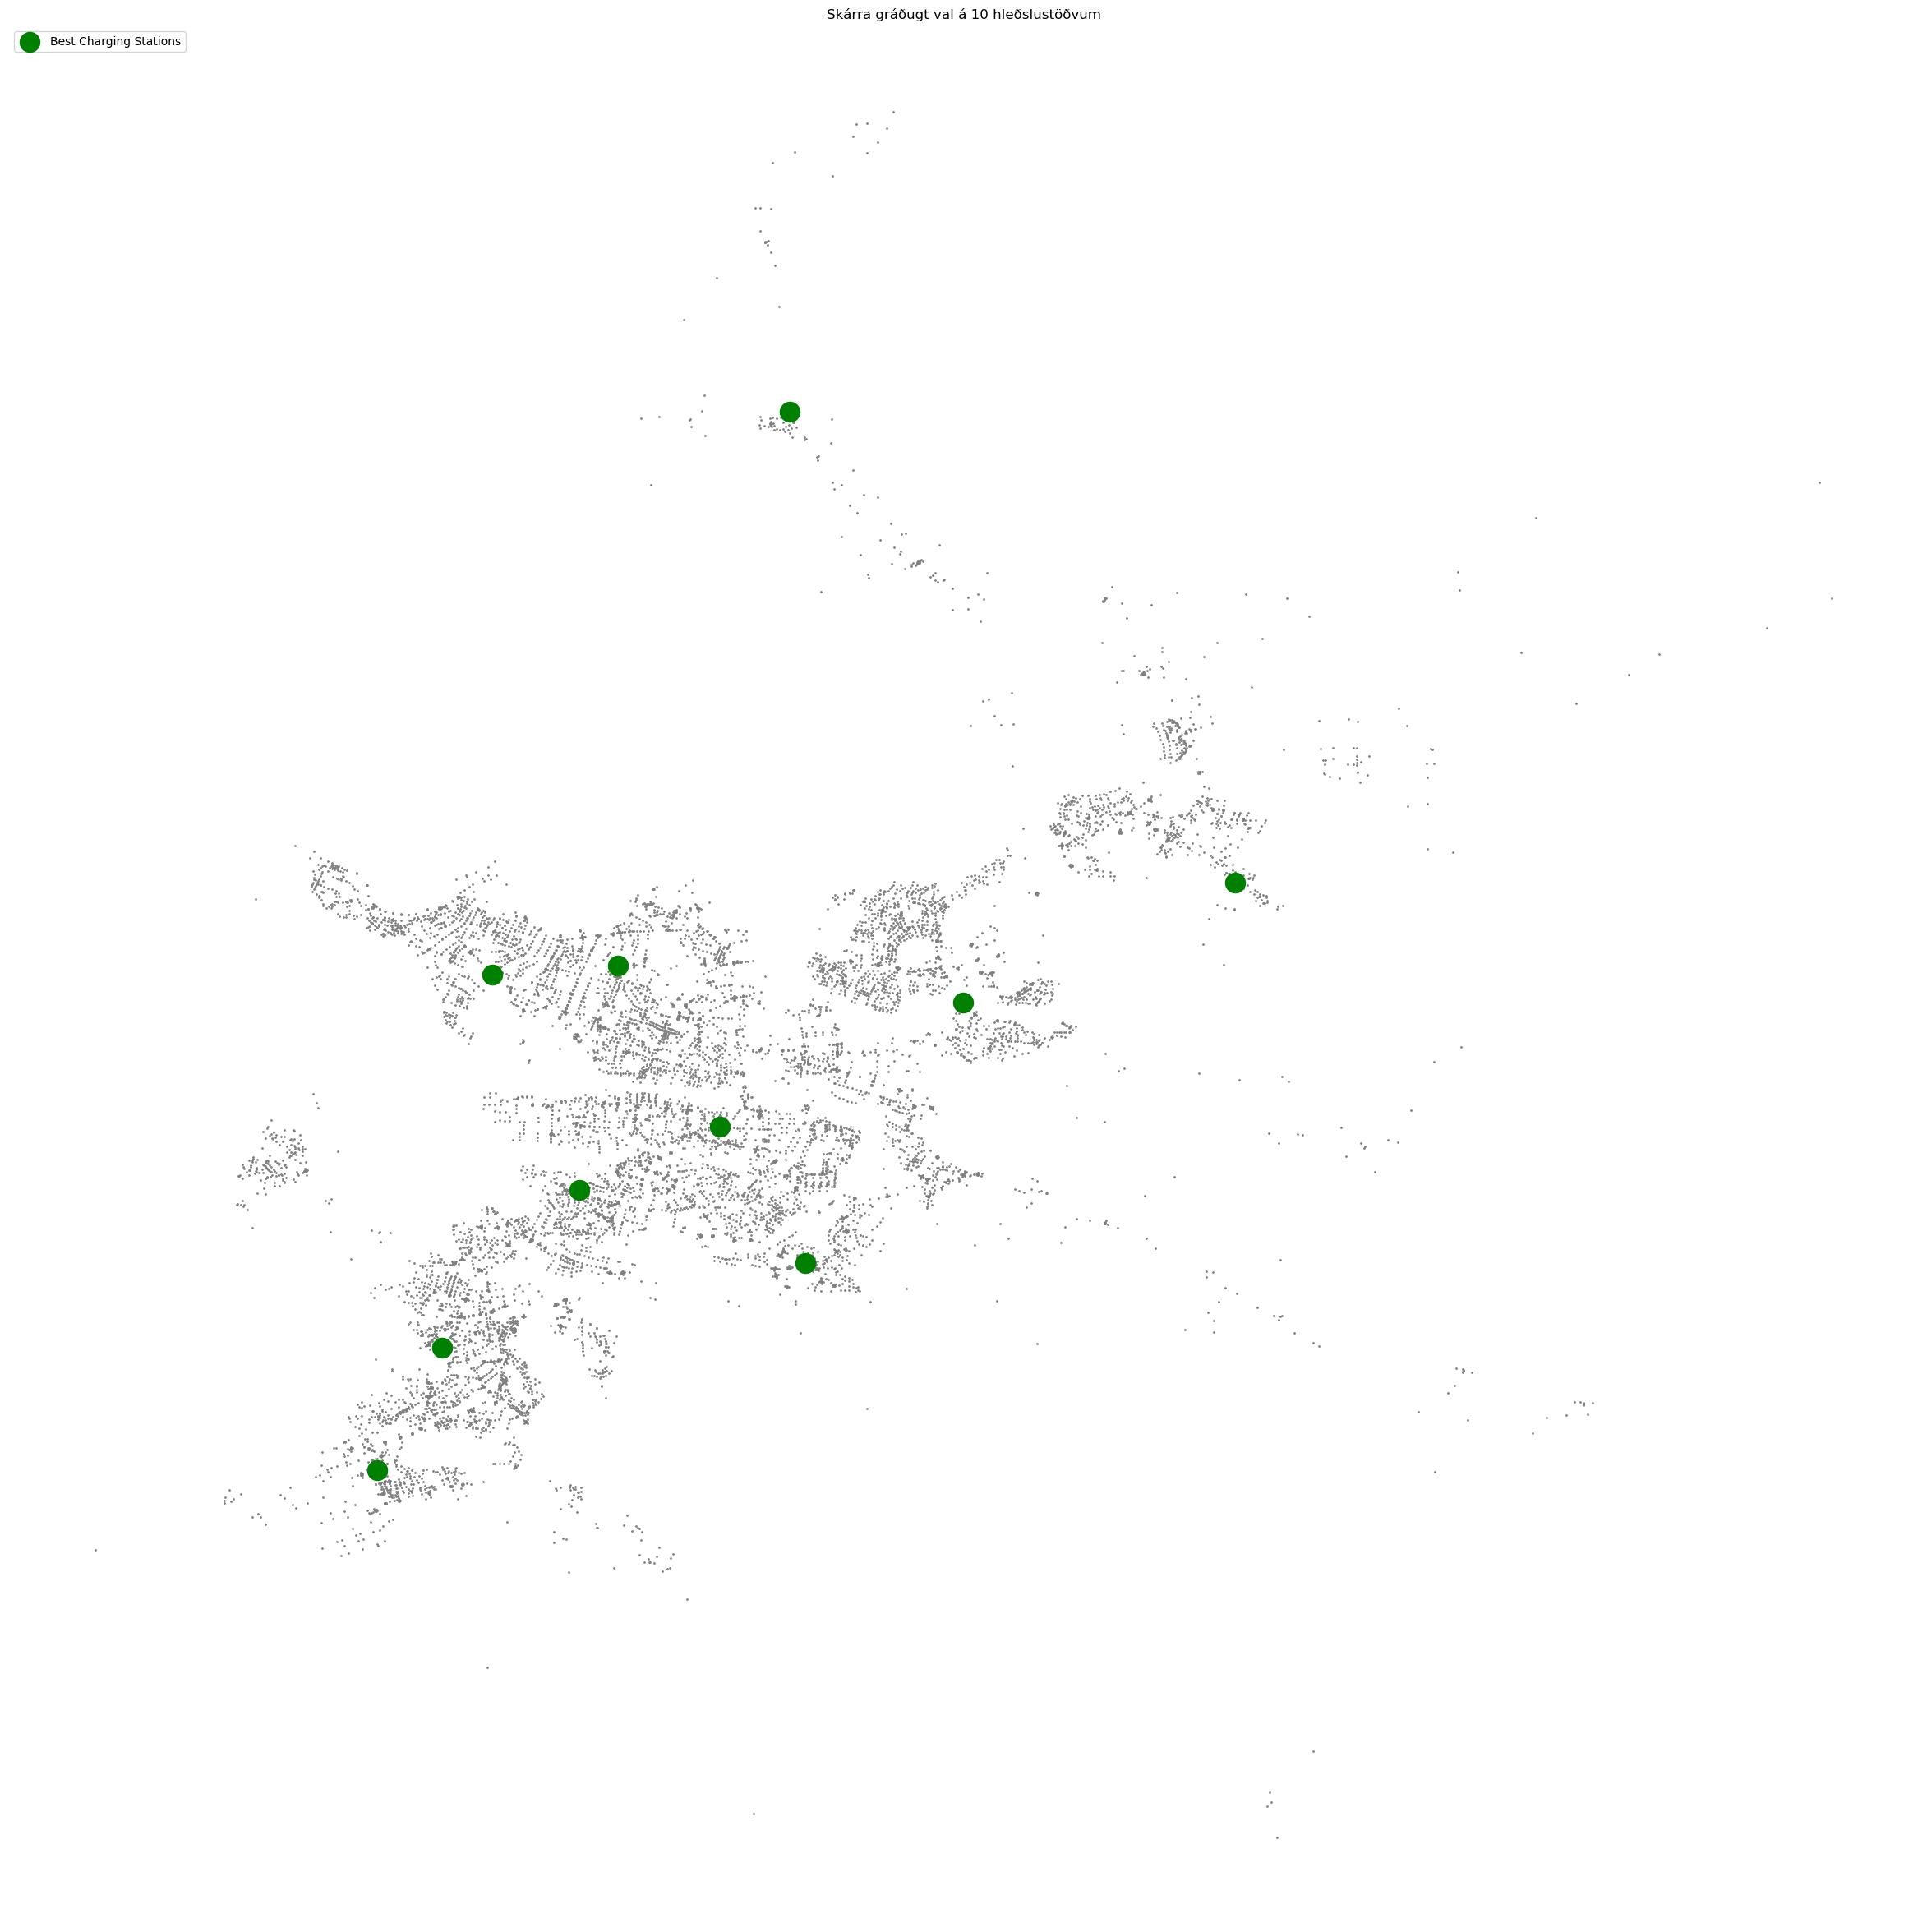

1. Hnútur: 34163853 — https://www.google.com/maps?q=64.1386136,-21.9400769
2. Hnútur: 35925270 — https://www.google.com/maps?q=64.1402006,-21.8932113
3. Hnútur: 56597878 — https://www.google.com/maps?q=64.133342,-21.7647614
4. Hnútur: 253238141 — https://www.google.com/maps?q=64.0850987,-21.8233776
5. Hnútur: 293964183 — https://www.google.com/maps?q=64.0467478,-21.9829557
6. Hnútur: 297899459 — https://www.google.com/maps?q=64.0987287,-21.9076808
7. Hnútur: 323368149 — https://www.google.com/maps?q=64.1103743,-21.8554359
8. Hnútur: 348723980 — https://www.google.com/maps?q=64.2428089,-21.8292392
9. Hnútur: 1962731900 — https://www.google.com/maps?q=64.1555865,-21.6634416
10. Hnútur: 4373077459 — https://www.google.com/maps?q=64.0694287,-21.95883


In [43]:
plt.figure(figsize=(30, 30))
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=1)
nx.draw_networkx_nodes(G, node_positions, nodelist=best_stations, node_color='green', node_size=300, label='Best Charging Stations')
plt.title("Skárra gráðugt val á 10 hleðslustöðvum")
plt.legend(loc='upper left')
plt.axis('off')
plt.show()

# Prenta staðsetningar á valdum stöðvum með Google Maps hlekk
for i, s in enumerate(best_stations):
    print(f"{i+1}. Hnútur: {s} — {gmaps_urls[s]}")

In [46]:
def compute_objective(graph, charging_nodes):
    dists = dijkstra_to_charging(graph, charging_nodes)
    return sum([d if d != float('inf') else 50000 for d in dists.values()])

markfall = compute_objective(graph, best_stations)
print(markfall)

25802604.824800454
